# 5.A. What is a recurrence matrix?

Most dynamical systems of interest evolve within a **bounded set**. This means that all trajectories move around in a specifc region in the phase space instead of escaping to infinity.

In such cases a **recurrence** is an event likely to happen (and most of the time it is guaranteed to happen). Recurrence simply means that a trajectory $x(t)$ "visits the neighborhood" of another trajectory $y(t)$ (or even the same trajectory $x$) at some other time point. A **Recurrence Matrix** is a way to list these recurrences.

To put it into more concrete terms, the recurrence matrix is defined as

$$
R[i, j] = \begin{cases}
1 \quad \text{if}\quad d(x[i], y[j]) \le \varepsilon\\
0 \quad \text{else}
\end{cases}
$$

with $d(x[i], y[j])$ the distance between the two trajectories at timepoints $i, j$. You can use different metrics for $d$ and by default we use the Euclidean.

Notice that $x$ can be single timeseries or full trajectories. $R$ is called _cross_ recurrence matrix for different $x, y$ and simply recurrence matrix if $x \equiv y$.

---

In the previous examples we have been looking at the Lorenz system in different regims. For starters lets see how the recurrence matrix the Lorenz system looks like in these cases

In [1]:
using DynamicalSystems
using PyPlot
PyPlot.rc("font", size = 16)          # set default fontsize
PyPlot.rc("figure", figsize = (6, 4)) # set default figsize

In [2]:
lor = Systems.lorenz()

3-dimensional continuous dynamical system
 state:       [0.0, 10.0, 0.0]
 e.o.m.:      loop
 in-place?    false
 jacobian:    loop_jac
 parameters:  [10.0, 28.0, 2.66667]

To create a recurrence matrix simply use `RecurrenceMatrix(trajectory, ε)` with `ε` the distance threshold.

In [3]:
set_parameter!(lor, 2, 69.75) # stable regime for Lorenz

t = 5.0
dt = 0.01

tr = trajectory(lor, t; dt = dt, Ttr = 2000.0)

R = RecurrenceMatrix(tr, 5.0)

        RecurrenceMatrix of size (501, 501) with 5275 entries
    ┌────────────────────────────────────────────────────────────┐ 
    │               .::'   ''                                 .::│
    │             .:'                                       .:'  │
    │          .::'                 ..                   .::'    │
    │        .:''                  '''                 .:''      │
    │     ..:'                                      ..:'         │
    │   .::'                                 ..   .::'           │
    │..:'                                  .:'  .:'              │
    │:' ..                                   .::' ..             │
    │ .:'                                  .:'' .:'              │
    │ '                                  .:'    '                │
    │                                 .:''                       │
    │         ...                  ..:'                  ..      │
    │         ''                 .::'                   ''       │

## 5.B. Recurrence plots

Internally a recurrence matrix is represented as a sparse matrix. 
What you see above is a simple ASCII-based plot of the matrix (with dots at non-zero elements). 

There are three ways to visualize a recurrence matrix:

1. Using `recurrenceplot` for a text-based plot (for use in e.g. a terminal). This is the only function that "plots" immediatelly
2. Using `coordinates` which returns the coordinates of the nonzero elements as scatter data.
3. Using `grayscale` which creates a grayscale matrix representation.

In [4]:
x, y = coordinates(R)
hcat(x, y)

5275×2 Array{Int64,2}:
   1    1
   1    2
   1    3
   1    4
   1    5
   1  348
   1  349
   1  350
   1  351
   1  352
   1  353
   1  354
   1  355
   ⋮     
 501  150
 501  151
 501  152
 501  153
 501  191
 501  192
 501  193
 501  194
 501  498
 501  499
 501  500
 501  501

To plot this one has to use the plotting library of their choice:

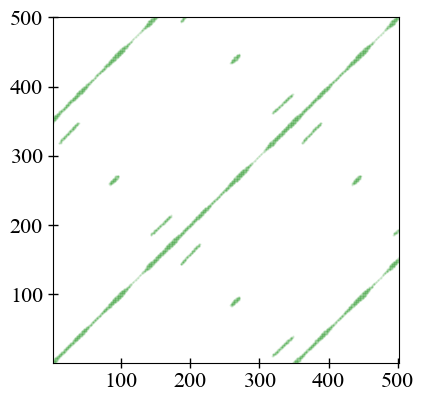

In [5]:
scatter(x, y, color = "C2", s = 1, alpha = 0.1)
xlim(1, size(R)[1]); ylim(1, size(R)[2]); gca()[:set_aspect]("equal")

Notice that the above plot has its axis in index coordinates. One can modify this by indexing the time vector of the trajectory, which by default is `0:dt:t`.

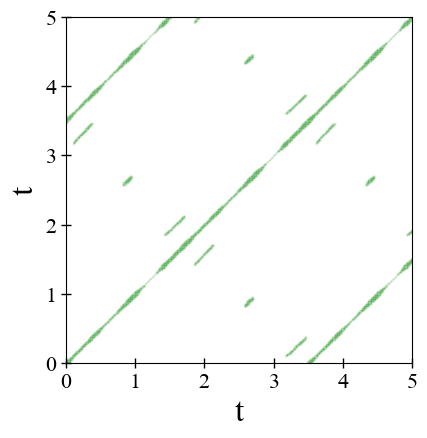

In [6]:
tvec = 0:dt:t

scatter(tvec[x], tvec[y], s = 1, color = "C2", alpha = 0.1)
xlim(0, t); ylim(0, t); gca()[:set_aspect]("equal")
xlabel("t"); ylabel("t");

## 5.C. Typical recurrence plots

In the previous notebooks we explored the Lorenz system in a regular and chaotic regime.
Here is a comparison of a recurrence plot of the Lorenz system in these two regimes:

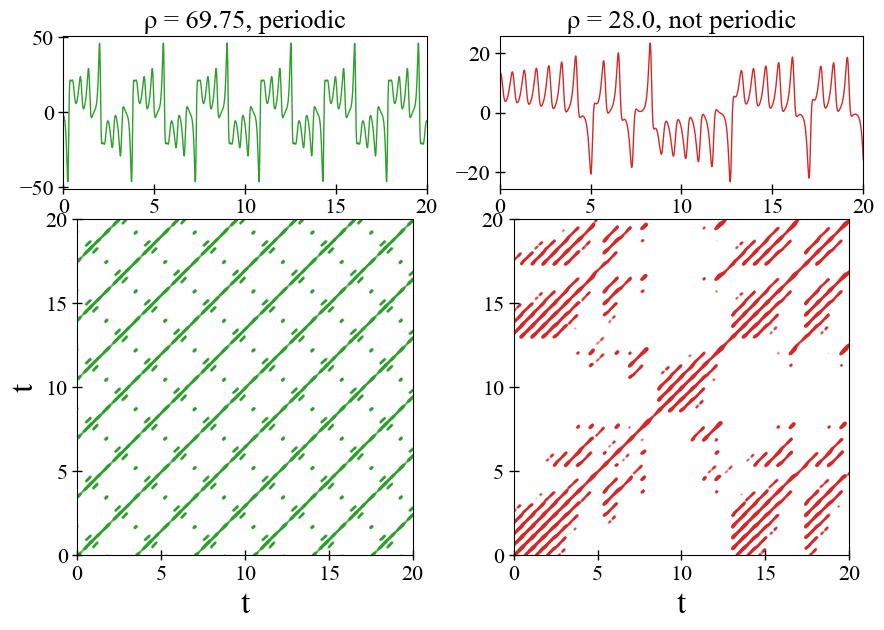

In [7]:
lor = Systems.lorenz()
figure(figsize = (10,6))

for (i, ρ) in enumerate((69.75, 28.0))
    set_parameter!(lor, 2, ρ)
    t, dt = 20.0, 0.01
    tr = trajectory(lor, t; dt = dt, Ttr = 200.0)
    tvec = 0:dt:t
    
    x = tr[:, 2]
    subplot2grid((3,2), (0, i-1))
    plot((0:dt:t), x, color = "C$(i+1)", lw = 1.0)
    xlim(0, t)
    title("ρ = $ρ, " * (i != 1 ? "not periodic" : "periodic"))    
    
    ε = i == 1 ? 5.0 : 3.0
    R = RecurrenceMatrix(tr, ε)
    
    subplot2grid((3,2), (1, i-1), rowspan = 2)
    x, y = coordinates(R)
    scatter(tvec[x], tvec[y], s = 1, alpha = 0.1, color = "C$(i+1)")
    xlim(0, t); ylim(0, t); gca()[:set_aspect]("equal")
    xlabel("t"); i == 1 && ylabel("t"); 
end

On the left we see long (potentially infinite) diagonals repeated for different times. This is the case for periodic systems as they visit exactly the same area on the phase space again and again. The vertical distance between the offset diagonals also coincides with the periodicity of the system, which is around `t ≈ 4`.

On the right we see a structure typical of chaotic motion on a strange attractor such as the one of the Lorenz system: the orbit visits neighborhoods of previous points but then quickly diverges again. This results in many small diagonal lines.

## 5.D. Using the recurrence matrix

Plots are great, but most of the time one needs to go further. What information can be obtained from recurrence matrices? 

There are a lot of measures that one can compute from a recurrence matrix. Too many in fact, so for this notebook we will consider only a few of them: `determinism`, maximum and average diagonal line length and `divergence` (which is simply 1/(maximum diagonal length)).

In [8]:
lor = Systems.lorenz()
for (i, ρ) in enumerate((69.75, 28.0))
    println("\nρ = $ρ ")
    set_parameter!(lor, 2, ρ)
    t, dt = 20.0, 0.01
    tr = trajectory(lor, t; dt = dt, Ttr = 200.0)
    
    ε = i == 1 ? 5.0 : 3.0
    R = RecurrenceMatrix(tr, ε)
    
    RQA = rqa(R, theiler = 4, lmin = 4)

    println("maximum diagonal: ", RQA.Lmax)
    println("average diagonal: ", RQA.L)
    println("determinism: ", RQA.DET)
    println("divergence (t-units): ", RQA.DIV/dt)
end


ρ = 69.75 
maximum diagonal: 1650
average diagonal: 30.24244966442953
determinism: 0.9950865376652773
divergence (t-units): 0.06060606060606061

ρ = 28.0 
maximum diagonal: 375
average diagonal: 35.43570903747245
determinism: 0.9974561022522802
divergence (t-units): 0.26666666666666666


What can we understand from these numbers? 

1. For periodic systems the maximum and average diagonals are not really meaningful quantities. Their true values are `Inf`.
2. In the chaotic regime the average and maximum diagonal length both serve as an estimate of the *divergence* of nearby trajectories.
3. "Determinism" simply measures the portion of diagonal lines in the recurrence plot. It can be interpreted as the "predictability" of the trajectory, in the sense that approximately close states should have approximately similar future for small times.
4. "Divergence" is equal to 1/(maximum diagonal). It is just a measure for how fast do trajectories diverge. Again, for the periodic system we know that it theoretically should be zero.

### A final example: Laminarity

Besides these diagonal lines, there are other things that may show up in a recurrence plot, given a different trajectory. An example is vertical lines, which appear in e.g. intermittent systems.

For example, it is known that the logistic map is intermittent just before the period 3 window, so let's look at its recurrence plot there:

In [9]:
logi = Systems.logistic(0.5; r = 3.828)

1-dimensional discrete dynamical system
 state:       0.5
 e.o.m.:      logistic_eom
 in-place?    false
 jacobian:    logistic_jacob
 parameters:  [3.828]

In the following I will use the **third iterate** of the logistic map (because the laminar phases are of period 3):

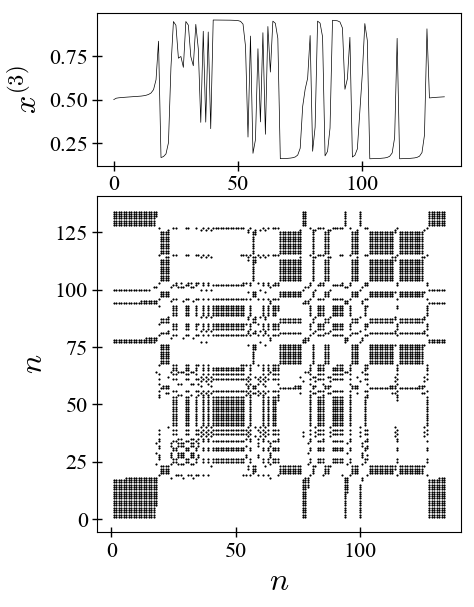

In [10]:
x3 = trajectory(logi, 400; dt = 3) # <- every 3rd point with dt = 3

R = RecurrenceMatrix(x3, 0.1)
x, y = coordinates(R)

figure(figsize = (10,6))

subplot2grid((3,2), (0, 0))
plot(x3, color = "k", lw=0.5)
ylabel("\$x^{(3)}\$");

subplot2grid((3,2), (1, 0), rowspan = 2)

scatter(x, y, s = 1, color = "k")
xlabel("\$n\$"); ylabel("\$n\$");

`laminarity` is a function that counts the portion of the vertical lines in the recurrence plot:

In [11]:
laminarity(R)

0.8034605732399949

This number tells us how big of a portion of the trajectory is spend in a "laminar" phase. Equivalently how much portion of the trajectory is spend around a constant number +/- `ε`.